# Tarea Final

In [127]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from Paquetes.HelperFunctions import violin_plot_numeric, null_percentage, value_counts_all_cols, train_models, validate_models
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder
from sklearn.base import BaseEstimator, ClassifierMixin, TransformerMixin
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import plotly.express as px
from tqdm import tqdm
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold, GroupKFold, RepeatedStratifiedKFold
import lightgbm as lgb
from sklearn.metrics import log_loss
import xgboost as xgb
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, recall_score, classification_report

# %matplotlib notebook

# https://www.kaggle.com/competitions/playground-series-s3e26/data?select=train.csv
# Load Dataset
df = pd.read_csv('data/train.csv')
df.head()

test_real_df = pd.read_csv('data/test.csv')
submission_df = pd.read_csv('data/submission.csv')

## Split Data

In [128]:
from sklearn.model_selection import train_test_split

# Use train_test_split to split the DataFrame
train_df, test_df = train_test_split(df, test_size=0.3, stratify=df['Status'])

test_IDs = test_df.id
test_IDs_real = test_real_df.id

# # Drop ID column
train_df.drop(columns=['id'], inplace=True)
test_df.drop(columns=['id'], inplace=True)
test_real_df.drop(columns=['id'], inplace=True)



In [129]:
test_real_df.head()

,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,3839,D-penicillamine,19724,F,N,Y,N,N,1.2,546.0,3.37,65.0,1636.0,151.90,90.0,430.0,10.6,2.0
1,2468,D-penicillamine,14975,F,N,N,N,N,1.1,660.0,4.22,94.0,1257.0,151.90,155.0,227.0,10.0,2.0
2,51,Placebo,13149,F,N,Y,N,Y,2.0,151.0,2.96,46.0,961.0,69.75,101.0,213.0,13.0,4.0
3,2330,D-penicillamine,20510,F,N,N,N,N,0.6,293.0,3.85,40.0,554.0,125.55,56.0,270.0,10.6,2.0
4,1615,D-penicillamine,21904,F,N,Y,N,N,1.4,277.0,2.97,121.0,1110.0,125.00,126.0,221.0,9.8,1.0


## EDA

In [130]:
train_df.head()

,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Status
84,1785,D-penicillamine,20256,F,N,Y,N,N,3.2,604.0,3.35,67.0,1840.0,170.50,64.0,268.0,11.0,4.0,D
1883,2891,D-penicillamine,13995,F,N,N,N,N,1.2,242.0,3.63,24.0,2520.0,92.00,114.0,326.0,10.0,2.0,C
333,2170,Placebo,20617,F,N,N,N,N,0.6,246.0,3.43,96.0,897.0,97.65,113.0,217.0,9.6,3.0,C
3866,2713,D-penicillamine,19544,F,N,Y,N,N,0.8,257.0,3.80,44.0,842.0,97.65,110.0,128.0,10.6,3.0,C
73,2105,Placebo,15105,F,N,N,N,N,0.6,204.0,3.35,28.0,1282.0,49.60,56.0,336.0,10.9,2.0,C


In [131]:
train_df.shape

(5533, 19)

In [132]:
test_df.head()

,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Status
5754,904,D-penicillamine,22388,F,N,Y,N,N,2.3,396.0,3.19,57.0,1440.0,134.85,131.0,156.0,10.0,4.0,D
420,1847,D-penicillamine,12279,F,N,Y,N,N,1.1,404.0,3.33,67.0,10165.0,79.05,224.0,156.0,10.1,2.0,C
3128,1235,Placebo,22111,M,N,N,N,N,0.8,329.0,3.93,52.0,1282.0,130.00,59.0,299.0,10.0,3.0,C
3867,850,Placebo,22646,F,N,Y,Y,N,2.8,242.0,3.11,74.0,614.0,136.40,104.0,121.0,13.2,3.0,D
4426,1433,Placebo,16929,F,N,Y,N,N,1.1,304.0,3.60,67.0,7277.0,151.90,146.0,252.0,10.6,3.0,C


In [133]:
test_df.shape

(2372, 19)

In [134]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5533 entries, 84 to 3740
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   N_Days         5533 non-null   int64  
 1   Drug           5533 non-null   object 
 2   Age            5533 non-null   int64  
 3   Sex            5533 non-null   object 
 4   Ascites        5533 non-null   object 
 5   Hepatomegaly   5533 non-null   object 
 6   Spiders        5533 non-null   object 
 7   Edema          5533 non-null   object 
 8   Bilirubin      5533 non-null   float64
 9   Cholesterol    5533 non-null   float64
 10  Albumin        5533 non-null   float64
 11  Copper         5533 non-null   float64
 12  Alk_Phos       5533 non-null   float64
 13  SGOT           5533 non-null   float64
 14  Tryglicerides  5533 non-null   float64
 15  Platelets      5533 non-null   float64
 16  Prothrombin    5533 non-null   float64
 17  Stage          5533 non-null   float64
 18  Status      

### Check Numerical Cols

In [135]:
numeric_cols = train_df.select_dtypes(include='number')
print(len(numeric_cols.columns))

12


In [136]:
print(type(numeric_cols))

<class 'pandas.core.frame.DataFrame'>


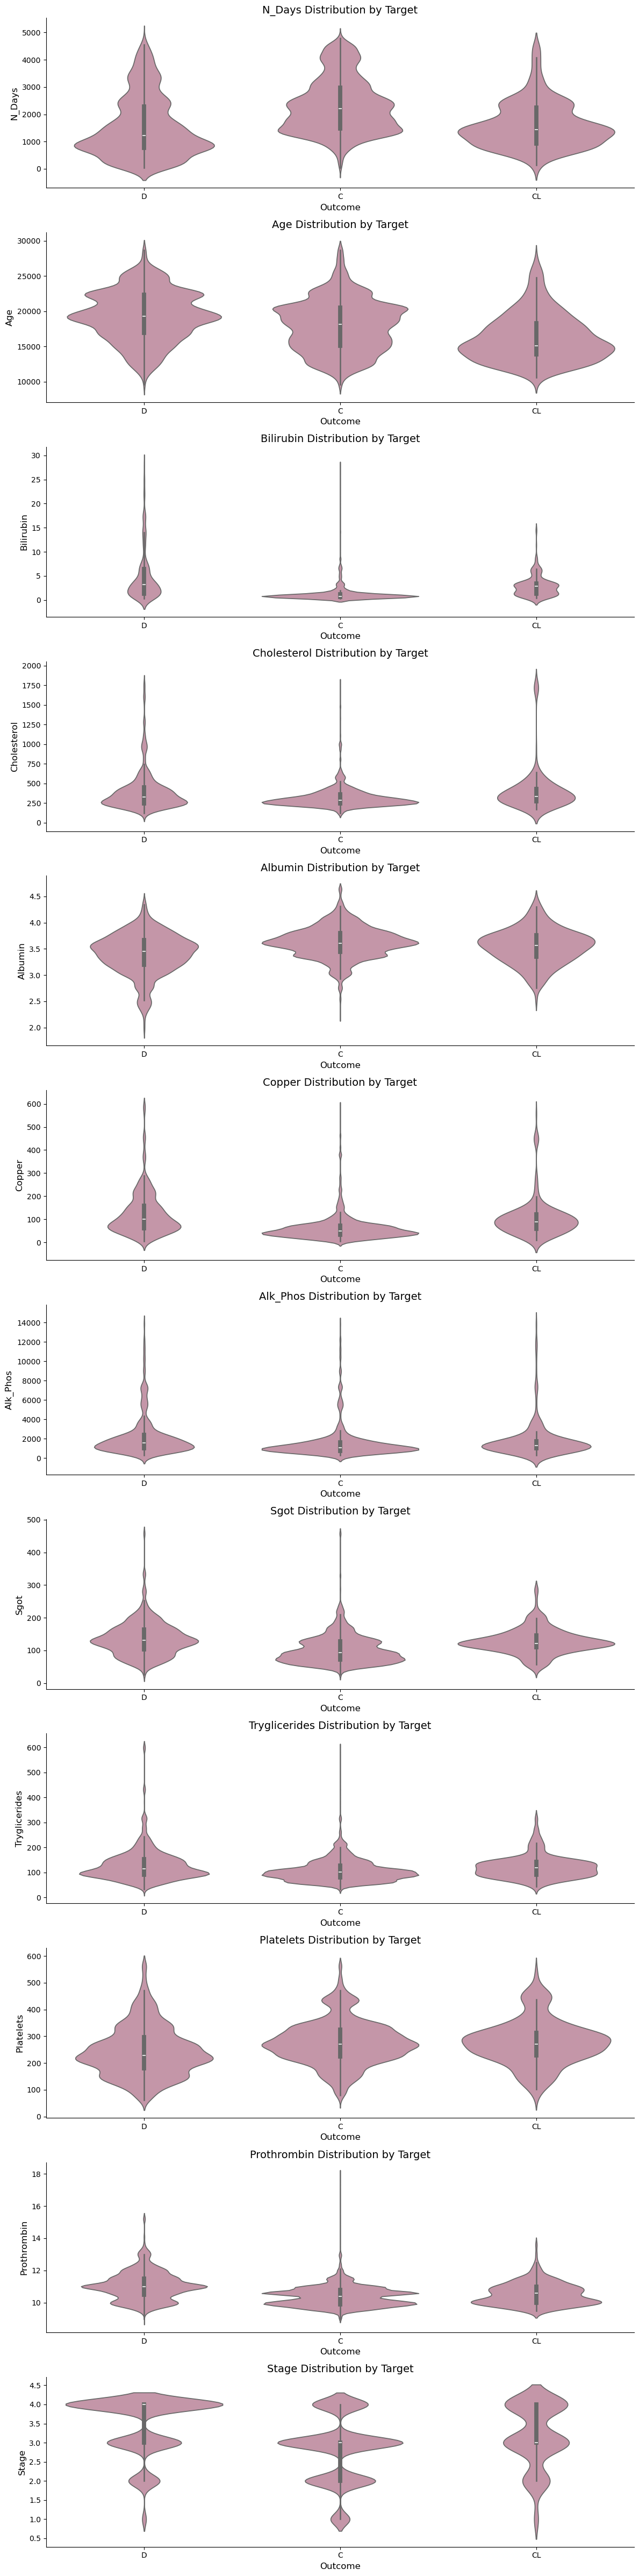

In [137]:
violin_plot_numeric(df, numeric_cols)

### Check Categorical Columns

In [138]:
cat_cols = train_df.select_dtypes(include='object')
cat_cols

,Drug,Sex,Ascites,Hepatomegaly,Spiders,Edema,Status
84,D-penicillamine,F,N,Y,N,N,D
1883,D-penicillamine,F,N,N,N,N,C
333,Placebo,F,N,N,N,N,C
3866,D-penicillamine,F,N,Y,N,N,C
73,Placebo,F,N,N,N,N,C
...,...,...,...,...,...,...,...
4584,Placebo,F,N,Y,N,N,D
4779,Placebo,F,N,N,N,N,C
349,D-penicillamine,F,N,N,N,N,C
6619,D-penicillamine,F,N,N,N,N,C


In [139]:
value_counts_all_cols(cat_cols)

Value Counts for : Drug
Placebo            2825
D-penicillamine    2708
Name: count, dtype: int64

Value Counts for : Sex
F    5119
M     414
Name: count, dtype: int64

Value Counts for : Ascites
N    5279
Y     254
Name: count, dtype: int64

Value Counts for : Hepatomegaly
Y    2796
N    2737
Name: count, dtype: int64

Value Counts for : Spiders
N    4159
Y    1374
Name: count, dtype: int64

Value Counts for : Edema
N    5023
S     283
Y     227
Name: count, dtype: int64

Value Counts for : Status
C     3475
D     1865
CL     193
Name: count, dtype: int64



* Drug: One-Hot Encoding
* Sex: Label encoding
* Ascites: Label Encoding
* Hepatomegaly: Label Encoding
* Spiders: Label Encoding
* Edema: One-Hot Encoding
* Status: Label Encoding

## Limpieza y Preprocesamiento de Datos

### Identificación y manejo de valores faltantes

In [140]:
null_percentage(train_df)

N_Days: total -> 0, percentage -> 0.00%
Drug: total -> 0, percentage -> 0.00%
Age: total -> 0, percentage -> 0.00%
Sex: total -> 0, percentage -> 0.00%
Ascites: total -> 0, percentage -> 0.00%
Hepatomegaly: total -> 0, percentage -> 0.00%
Spiders: total -> 0, percentage -> 0.00%
Edema: total -> 0, percentage -> 0.00%
Bilirubin: total -> 0, percentage -> 0.00%
Cholesterol: total -> 0, percentage -> 0.00%
Albumin: total -> 0, percentage -> 0.00%
Copper: total -> 0, percentage -> 0.00%
Alk_Phos: total -> 0, percentage -> 0.00%
SGOT: total -> 0, percentage -> 0.00%
Tryglicerides: total -> 0, percentage -> 0.00%
Platelets: total -> 0, percentage -> 0.00%
Prothrombin: total -> 0, percentage -> 0.00%
Stage: total -> 0, percentage -> 0.00%
Status: total -> 0, percentage -> 0.00%


* No null values in the training set

### Codificación de variable categoricas

#### One-Hot Encoding

In [141]:
from Paquetes.HelperFunctions import one_hot_encoding
one_hot_cols = ['Edema']

train_df = one_hot_encoding(train_df, one_hot_cols)
test_df = one_hot_encoding(test_df, one_hot_cols)
test_real_df = one_hot_encoding(test_real_df, one_hot_cols)

In [142]:
test_real_df.head()

,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Edema_N,Edema_S,Edema_Y
0,3839,D-penicillamine,19724,F,N,Y,N,1.2,546.0,3.37,65.0,1636.0,151.90,90.0,430.0,10.6,2.0,True,False,False
1,2468,D-penicillamine,14975,F,N,N,N,1.1,660.0,4.22,94.0,1257.0,151.90,155.0,227.0,10.0,2.0,True,False,False
2,51,Placebo,13149,F,N,Y,N,2.0,151.0,2.96,46.0,961.0,69.75,101.0,213.0,13.0,4.0,False,False,True
3,2330,D-penicillamine,20510,F,N,N,N,0.6,293.0,3.85,40.0,554.0,125.55,56.0,270.0,10.6,2.0,True,False,False
4,1615,D-penicillamine,21904,F,N,Y,N,1.4,277.0,2.97,121.0,1110.0,125.00,126.0,221.0,9.8,1.0,True,False,False


#### Label Encoding

In [143]:
le_cols = ['Drug','Sex','Ascites', 'Hepatomegaly', 'Spiders', 'Status']
value_counts_all_cols(train_df, le_cols)

Value Counts for : Drug
Placebo            2825
D-penicillamine    2708
Name: count, dtype: int64

Value Counts for : Sex
F    5119
M     414
Name: count, dtype: int64

Value Counts for : Ascites
N    5279
Y     254
Name: count, dtype: int64

Value Counts for : Hepatomegaly
Y    2796
N    2737
Name: count, dtype: int64

Value Counts for : Spiders
N    4159
Y    1374
Name: count, dtype: int64

Value Counts for : Status
C     3475
D     1865
CL     193
Name: count, dtype: int64



In [144]:
from Paquetes.HelperFunctions import label_encoding


le_cols = ['Drug','Sex','Ascites', 'Hepatomegaly', 'Spiders', 'Status']
le_cols_test_real = ['Drug','Sex','Ascites', 'Hepatomegaly', 'Spiders']
cols_dict = {'Drug': {'D-penicillamine': 0, 'Placebo': 1}, 'Sex': {"F":0,"M":1}, 'Ascites':{'N':0,'Y':1}, 'Hepatomegaly': {'N':0,'Y':1}, 'Spiders': {'N':0,'Y':1}, 'Status': {'C':0,'D':1,'CL':2} }
cols_dict_test_real = {'Drug': {'D-penicillamine': 0, 'Placebo': 1}, 'Sex': {"F":0,"M":1}, 'Ascites':{'N':0,'Y':1}, 'Hepatomegaly': {'N':0,'Y':1}, 'Spiders': {'N':0,'Y':1} }
label_encoding(train_df, le_cols, cols_dict)
label_encoding(test_df, le_cols, cols_dict)
label_encoding(test_real_df, le_cols_test_real, cols_dict_test_real)


,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Edema_N,Edema_S,Edema_Y
0,3839,0,19724,0,0,1,0,1.2,546.0,3.37,65.0,1636.0,151.90,90.0,430.0,10.6,2.0,True,False,False
1,2468,0,14975,0,0,0,0,1.1,660.0,4.22,94.0,1257.0,151.90,155.0,227.0,10.0,2.0,True,False,False
2,51,1,13149,0,0,1,0,2.0,151.0,2.96,46.0,961.0,69.75,101.0,213.0,13.0,4.0,False,False,True
3,2330,0,20510,0,0,0,0,0.6,293.0,3.85,40.0,554.0,125.55,56.0,270.0,10.6,2.0,True,False,False
4,1615,0,21904,0,0,1,0,1.4,277.0,2.97,121.0,1110.0,125.00,126.0,221.0,9.8,1.0,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5266,2870,1,12279,0,0,0,0,1.3,302.0,3.43,75.0,1345.0,145.00,44.0,181.0,10.6,3.0,True,False,False
5267,1770,1,24803,0,0,0,0,0.5,219.0,4.09,121.0,663.0,79.05,94.0,311.0,9.7,3.0,True,False,False
5268,3707,0,16990,0,0,1,0,0.8,315.0,4.09,13.0,1637.0,170.50,70.0,426.0,10.9,3.0,True,False,False
5269,1216,1,11773,0,0,0,0,0.7,329.0,3.80,52.0,678.0,57.00,126.0,306.0,10.2,1.0,True,False,False


In [145]:
le_cols = ['Drug','Sex','Ascites', 'Hepatomegaly', 'Spiders', 'Status']
value_counts_all_cols(test_real_df, le_cols_test_real)

print(len(train_df))

Value Counts for : Drug
1    2694
0    2577
Name: count, dtype: int64

Value Counts for : Sex
0    4877
1     394
Name: count, dtype: int64

Value Counts for : Ascites
0    5027
1     244
Name: count, dtype: int64

Value Counts for : Hepatomegaly
1    2730
0    2541
Name: count, dtype: int64

Value Counts for : Spiders
0    3972
1    1299
Name: count, dtype: int64

5533


In [146]:
test_real_df.head()

,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Edema_N,Edema_S,Edema_Y
0,3839,0,19724,0,0,1,0,1.2,546.0,3.37,65.0,1636.0,151.90,90.0,430.0,10.6,2.0,True,False,False
1,2468,0,14975,0,0,0,0,1.1,660.0,4.22,94.0,1257.0,151.90,155.0,227.0,10.0,2.0,True,False,False
2,51,1,13149,0,0,1,0,2.0,151.0,2.96,46.0,961.0,69.75,101.0,213.0,13.0,4.0,False,False,True
3,2330,0,20510,0,0,0,0,0.6,293.0,3.85,40.0,554.0,125.55,56.0,270.0,10.6,2.0,True,False,False
4,1615,0,21904,0,0,1,0,1.4,277.0,2.97,121.0,1110.0,125.00,126.0,221.0,9.8,1.0,True,False,False


In [147]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5533 entries, 84 to 3740
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   N_Days         5533 non-null   int64  
 1   Drug           5533 non-null   int64  
 2   Age            5533 non-null   int64  
 3   Sex            5533 non-null   int64  
 4   Ascites        5533 non-null   int64  
 5   Hepatomegaly   5533 non-null   int64  
 6   Spiders        5533 non-null   int64  
 7   Bilirubin      5533 non-null   float64
 8   Cholesterol    5533 non-null   float64
 9   Albumin        5533 non-null   float64
 10  Copper         5533 non-null   float64
 11  Alk_Phos       5533 non-null   float64
 12  SGOT           5533 non-null   float64
 13  Tryglicerides  5533 non-null   float64
 14  Platelets      5533 non-null   float64
 15  Prothrombin    5533 non-null   float64
 16  Stage          5533 non-null   float64
 17  Status         5533 non-null   int64  
 18  Edema_N     

## Modelado y Evaluación

### Selección de Características

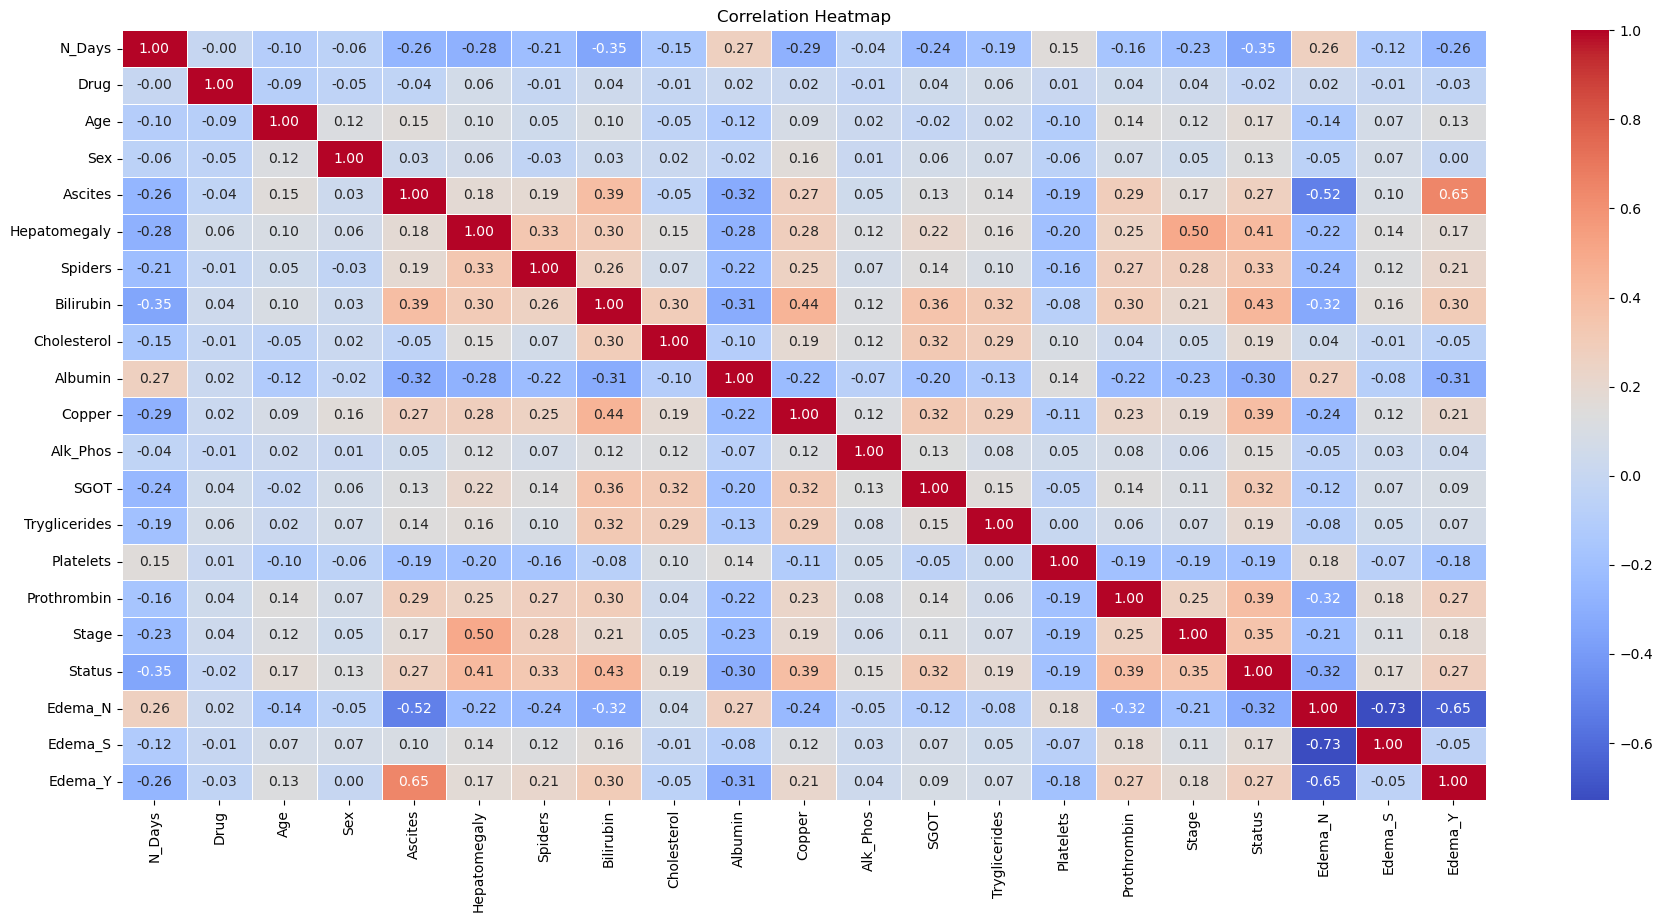

In [148]:
from Paquetes.HelperFunctions import corr_heatmap

corr = corr_heatmap(train_df)

In [149]:
LABEL = "Status"
CAT_FEATS = ["Drug", "Sex", "Ascites", "Hepatomegaly", "Spiders", "Edema", "Stage"]
NUM_FEATS = [x for x in train_df.columns if x not in CAT_FEATS and x != LABEL]

### Feature Engineering

In [150]:

class DiagnosisDateTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X['Diagnosis_Date'] = X['Age'] - X['N_Days']
        return X
    
class AgeYearsTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X['Age_Years'] = round(X['Age'] / 365.25).astype("int16")
        return X

class AgeGroupsTransformer(BaseEstimator, TransformerMixin):
    """Older people might be hit harder (interaction) by health issues. Also can cover lifestyle influences, i.e.
    alcohol consumption etc."""
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        # Use years from above, min=26, max=78
        X['Age_Group'] = pd.cut(X['Age_Years'], bins=[19, 29, 49, 64, 99], labels = [0, 1, 2, 3]).astype('int16')
        return X

class BilirubinAlbuminTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X['Bilirubin_Albumin'] = X['Bilirubin'] * X['Albumin']
        return X

class DrugEffectivenessTransformer(BaseEstimator, TransformerMixin):
    # Placeholder concept, assuming 'Bilirubin' improvement is a measure of effectiveness
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X['Drug_Effectiveness'] = X['Drug'] * X['Bilirubin']
        return X

class SymptomScoreTransformer(BaseEstimator, TransformerMixin):
    # From data set explanations above let's add all the "bad" symptoms
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        # symptom_columns = ['Ascites', 'Hepatomegaly', 'Spiders', 'Edema']
        symptom_columns = ['Ascites', 'Hepatomegaly', 'Spiders', 'Edema_N', 'Edema_S', 'Edema_Y']
        X['Symptom_Score'] = X[symptom_columns].sum(axis=1)
        return X
    
class SymptomCatTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.symptom_columns = ['Ascites', 'Hepatomegaly', 'Spiders', 'Edema_N', 'Edema_S', 'Edema_Y']
        self.encoder = OneHotEncoder(handle_unknown='ignore')

    def fit(self, X, y=None):
        X_copy = X.copy()
        symptom_scores = X_copy[self.symptom_columns].apply(lambda row: ''.join(row.values.astype(str)), axis=1)
        self.encoder.fit(symptom_scores.values.reshape(-1, 1))
        return self

    def transform(self, X):
        X_transformed = X.copy()
        symptom_scores = X_transformed[self.symptom_columns].apply(lambda row: ''.join(row.values.astype(str)), axis=1)
        encoded_features = self.encoder.transform(symptom_scores.values.reshape(-1, 1)).toarray().astype("int8")
        encoded_feature_names = self.encoder.get_feature_names_out(input_features=['Symptom_Score'])
        # Drop the original symptom columns and add the new encoded features
        # X_transformed.drop(columns=self.symptom_columns, inplace=True)
        X_transformed[encoded_feature_names] = pd.DataFrame(encoded_features, index=X_transformed.index)
        
        return X_transformed


class LiverFunctionTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        liver_columns = ['Bilirubin', 'Albumin', 'Alk_Phos', 'SGOT']
        X['Liver_Function_Index'] = X[liver_columns].mean(axis=1)
        return X

class RiskScoreTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X['Risk_Score'] = X['Bilirubin'] + X['Albumin'] - X['Alk_Phos']
        return X

class TimeFeaturesTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X['Diag_Year'] = (X['N_Days'] / 365).astype(int)
        X['Diag_Month'] = ((X['N_Days'] % 365) / 30).astype(int)
        return X
    
class ScalingTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.scaler = StandardScaler()
        self.num_feats = NUM_FEATS + ['Diagnosis_Date', 'Age_Years', 'Bilirubin_Albumin', 'Drug_Effectiveness', 
                                      'Symptom_Score', 'Liver_Function_Index', 'Risk_Score', 'Diag_Year', 'Diag_Month']

    def fit(self, X, y=None):
        self.scaler.fit(X[self.num_feats])
        return self

    def transform(self, X):
        X_scaled = X.copy()
        X_scaled[self.num_feats] = self.scaler.transform(X_scaled[self.num_feats])
        return X_scaled

# Define the pipeline
pipeline = Pipeline([
    ('diagnosis_date', DiagnosisDateTransformer()),
    ('age_years', AgeYearsTransformer()),
    ('age_groups', AgeGroupsTransformer()),
    ('bilirubin_albumin', BilirubinAlbuminTransformer()),
    ('drug_effectiveness', DrugEffectivenessTransformer()),
    ('symptom_score', SymptomScoreTransformer()),
    ('symptom_cat_score', SymptomCatTransformer()),
    ('liver_function', LiverFunctionTransformer()),
    ('risk_score', RiskScoreTransformer()),
    ('time_features', TimeFeaturesTransformer()),
    #('scaling', ScalingTransformer()),
    # ... ?
])

# Apply the pipeline to your dataframes
train_df_mod = pipeline.fit_transform(train_df)
test_df_mod = pipeline.transform(test_df)
test_df_real_mod = pipeline.transform(test_real_df)
train_df_mod['Symptom_Score'] = pd.to_numeric(train_df_mod['Symptom_Score'], errors='coerce')
test_df_mod['Symptom_Score'] = pd.to_numeric(test_df_mod['Symptom_Score'], errors='coerce')
test_df_real_mod['Symptom_Score'] = pd.to_numeric(test_df_real_mod['Symptom_Score'], errors='coerce')

# Update the CAT_FEATS
CAT_FEATS = ['Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema', 'Stage', #old
             'Age_Group', 'Symptom_Score'] # new 
# Update the NUM_FEATS ????

In [151]:
train_df_mod.head()

,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Status,Edema_N,Edema_S,Edema_Y,Diagnosis_Date,Age_Years,Age_Group,Bilirubin_Albumin,Drug_Effectiveness,Symptom_Score,Symptom_Score_000FalseFalseTrue,Symptom_Score_000FalseTrueFalse,Symptom_Score_000TrueFalseFalse,Symptom_Score_001FalseFalseTrue,Symptom_Score_001FalseTrueFalse,Symptom_Score_001TrueFalseFalse,Symptom_Score_010FalseFalseTrue,Symptom_Score_010FalseTrueFalse,Symptom_Score_010TrueFalseFalse,Symptom_Score_011FalseFalseTrue,Symptom_Score_011FalseTrueFalse,Symptom_Score_011TrueFalseFalse,Symptom_Score_100FalseFalseTrue,Symptom_Score_100FalseTrueFalse,Symptom_Score_101FalseFalseTrue,Symptom_Score_101TrueFalseFalse,Symptom_Score_110FalseFalseTrue,Symptom_Score_110FalseTrueFalse,Symptom_Score_110TrueFalseFalse,Symptom_Score_111FalseFalseTrue,Symptom_Score_111FalseTrueFalse,Symptom_Score_111TrueFalseFalse,Liver_Function_Index,Risk_Score,Diag_Year,Diag_Month
84,1785,0,20256,0,0,1,0,3.2,604.0,3.35,67.0,1840.0,170.50,64.0,268.0,11.0,4.0,2,True,False,False,18471,55,2,10.720,0.0,2,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,504.2625,-1833.45,4,10
1883,2891,0,13995,0,0,0,0,1.2,242.0,3.63,24.0,2520.0,92.00,114.0,326.0,10.0,2.0,0,True,False,False,11104,38,1,4.356,0.0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,654.2075,-2515.17,7,11
333,2170,1,20617,0,0,0,0,0.6,246.0,3.43,96.0,897.0,97.65,113.0,217.0,9.6,3.0,0,True,False,False,18447,56,2,2.058,0.6,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,249.6700,-892.97,5,11
3866,2713,0,19544,0,0,1,0,0.8,257.0,3.80,44.0,842.0,97.65,110.0,128.0,10.6,3.0,0,True,False,False,16831,54,2,3.040,0.0,2,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,236.0625,-837.40,7,5
73,2105,1,15105,0,0,0,0,0.6,204.0,3.35,28.0,1282.0,49.60,56.0,336.0,10.9,2.0,0,True,False,False,13000,41,1,2.010,0.6,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,333.8875,-1278.05,5,9


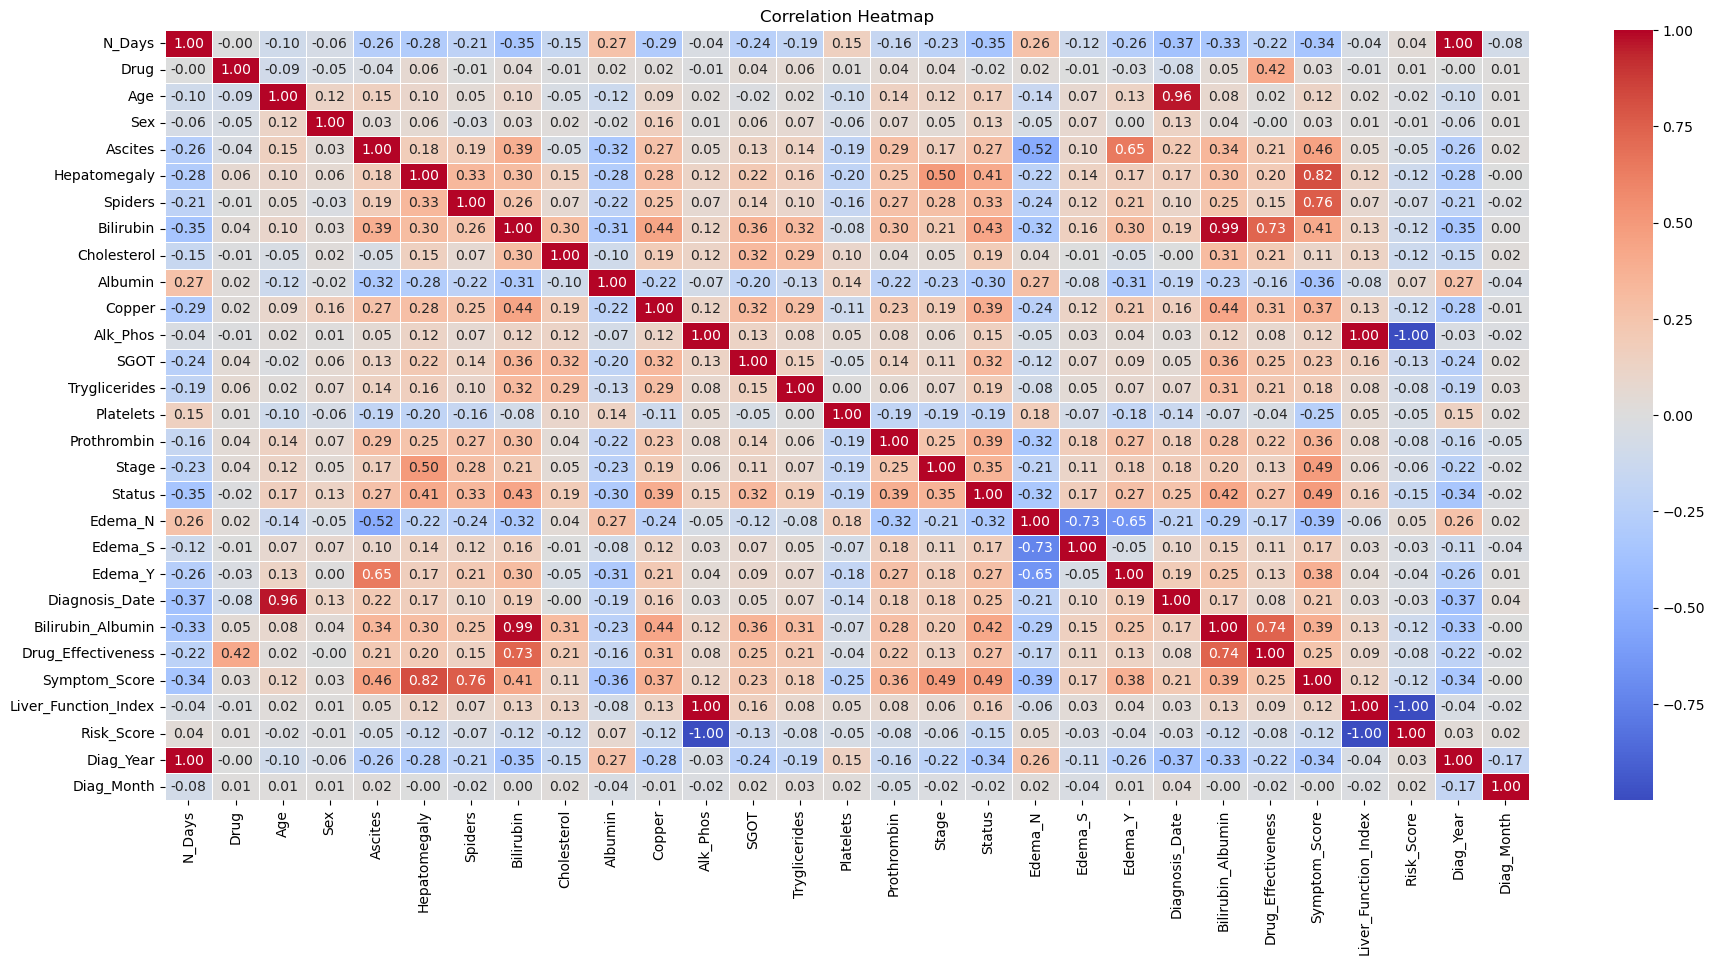

,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Status,Edema_N,Edema_S,Edema_Y,Diagnosis_Date,Bilirubin_Albumin,Drug_Effectiveness,Symptom_Score,Liver_Function_Index,Risk_Score,Diag_Year,Diag_Month
N_Days,1.000000,-0.001407,-0.098395,-0.059244,-0.261341,-0.283685,-0.211334,-0.349379,-0.152974,0.265068,-0.289716,-0.035694,-0.243503,-0.192147,0.149884,-0.162185,-0.225486,-0.345571,0.264931,-0.115071,-0.258567,-0.369067,-0.334036,-0.219731,-0.344936,-0.042282,0.035057,0.995521,-0.079339
Drug,-0.001407,1.000000,-0.086039,-0.045865,-0.035736,0.064676,-0.007136,0.038063,-0.011560,0.020019,0.020086,-0.013298,0.044667,0.062391,0.008791,0.043660,0.036082,-0.015404,0.024237,-0.005731,-0.028982,-0.079965,0.046598,0.416492,0.026094,-0.012053,0.013380,-0.002435,0.013943
Age,-0.098395,-0.086039,1.000000,0.121302,0.154636,0.097504,0.046765,0.096621,-0.045907,-0.119886,0.087528,0.022049,-0.016313,0.023172,-0.103327,0.141924,0.121071,0.169755,-0.142200,0.073413,0.125845,0.961207,0.079771,0.017371,0.121416,0.021727,-0.021884,-0.098528,0.014323
Sex,-0.059244,-0.045865,0.121302,1.000000,0.032806,0.056046,-0.028313,0.032644,0.020285,-0.023134,0.156593,0.012998,0.061507,0.066504,-0.055126,0.070083,0.046011,0.126990,-0.054237,0.071171,0.000052,0.129709,0.037667,-0.002792,0.027149,0.014545,-0.012940,-0.059965,0.014479
Ascites,-0.261341,-0.035736,0.154636,0.032806,1.000000,0.182479,0.185742,0.390076,-0.045470,-0.321657,0.273141,0.047888,0.127291,0.139789,-0.190167,0.285274,0.168271,0.270501,-0.518227,0.098035,0.646889,0.216857,0.337244,0.209223,0.456304,0.051598,-0.047184,-0.259913,0.019822
Hepatomegaly,-0.283685,0.064676,0.097504,0.056046,0.182479,1.000000,0.333569,0.304595,0.149095,-0.281125,0.282259,0.117456,0.215374,0.160226,-0.201822,0.250178,0.496628,0.412057,-0.221539,0.136180,0.171839,0.169692,0.295157,0.196735,0.817631,0.122939,-0.116929,-0.280018,-0.001541
Spiders,-0.211334,-0.007136,0.046765,-0.028313,0.185742,0.333569,1.000000,0.255282,0.065904,-0.217805,0.253272,0.069275,0.139954,0.096960,-0.163626,0.272595,0.280913,0.331159,-0.240567,0.122902,0.214336,0.102251,0.247751,0.145514,0.764199,0.072971,-0.068823,-0.207021,-0.016984
Bilirubin,-0.349379,0.038063,0.096621,0.032644,0.390076,0.304595,0.255282,1.000000,0.297645,-0.313375,0.441065,0.118704,0.356378,0.319081,-0.078719,0.296031,0.209114,0.432381,-0.324215,0.156161,0.299387,0.187076,0.988828,0.728698,0.412505,0.129071,-0.116806,-0.345184,0.002588
Cholesterol,-0.152974,-0.011560,-0.045907,0.020285,-0.045470,0.149095,0.065904,0.297645,1.000000,-0.096964,0.188834,0.124341,0.323234,0.289180,0.095890,0.039158,0.045740,0.188549,0.043073,-0.007780,-0.054176,-0.000474,0.307122,0.210029,0.112050,0.132512,-0.123796,-0.153382,0.023416
Albumin,0.265068,0.020019,-0.119886,-0.023134,-0.321657,-0.281125,-0.217805,-0.313375,-0.096964,1.000000,-0.222443,-0.072266,-0.201846,-0.129330,0.138183,-0.217057,-0.229858,-0.304025,0.274133,-0.081596,-0.309164,-0.185435,-0.228911,-0.157441,-0.361880,-0.077472,0.071840,0.265710,-0.041812


In [152]:
corr_heatmap(train_df_mod)

In [153]:
label_encoder = LabelEncoder()
def tsne_with_feature_selection_and_pca(data, num_feats, target_column, n_components=2, top_n_features=10, pca_components=None):
    """
    Select top features based on feature importance, optionally apply PCA, and then use t-SNE for visualization.

    Parameters:
    data (DataFrame): The input data.
    num_feats (list): List of numerical feature column names.
    target_column (str): The name of the target column.
    n_components (int): Number of dimensions for t-SNE (2 or 3). Default is 2.
    top_n_features (int): Number of top features to select based on importance. Default is 10.
    pca_components (int or None): Number of PCA components to retain before applying t-SNE. If None, PCA is not applied.
    """
    
    global label_encoder
    
    # Standardizing the numerical features
    scaler = StandardScaler()
    numerical_data_scaled = scaler.fit_transform(data[num_feats])

    # Random Forest for feature importances
    rf = RandomForestClassifier(random_state=42)
    rf.fit(numerical_data_scaled, data[target_column])
    importances = rf.feature_importances_

    # Selecting top_n_features
    indices = np.argsort(importances)[-top_n_features:]
    selected_features = [num_feats[i] for i in indices]

    # Data for t-SNE
    tsne_data = numerical_data_scaled[:, indices]

    # Optionally applying PCA
    if pca_components is not None and pca_components < len(selected_features):
        pca = PCA(n_components=pca_components)
        tsne_data = pca.fit_transform(tsne_data)

    # Applying t-SNE
    tsne = TSNE(n_components=n_components, learning_rate='auto', init='random', perplexity=30, random_state=42)
    tsne_results = tsne.fit_transform(tsne_data)

    # Creating a DataFrame for the t-SNE results
    tsne_df = pd.DataFrame(tsne_results, columns=[f'Component {i+1}' for i in range(n_components)])
    tsne_df[target_column] = label_encoder.inverse_transform(data[target_column].values)

    # Visualizing using Plotly
    if n_components == 3:
        fig = px.scatter_3d(tsne_df, x='Component 1', y='Component 2', z='Component 3', color=target_column)
    else:
        fig = px.scatter(tsne_df, x='Component 1', y='Component 2', color=target_column)
    
    fig.update_layout(width=800, height=600)
    fig.show()

train_df_red = train_df_mod
# tsne_with_feature_selection_and_pca(train_df_red, NUM_FEATS, LABEL, n_components=3, top_n_features=10, pca_components=None)

In [154]:
# Features to combine 
# All
#df_train_pca = df_train_mod.drop([LABEL], axis=1)
#df_test_pca = df_test_mod

# Numerical feats
df_train_pca = train_df_mod[NUM_FEATS]
df_test_pca = test_df_mod[NUM_FEATS]
test_real_df_pca = test_df_real_mod[NUM_FEATS]

# Some, the feats here are taken iteratively from previous runs
#FEATS = ['Platelets', 'Copper', 'Alk_Phos', 'Diagnosis_Date', 'SGOT', 'Age', 'N_Days']
#PCA_FEATS = [c for c in df_train_mod.drop(LABEL, axis=1).columns.values if c not in FEATS]
#df_train_pca = df_train_mod[PCA_FEATS]
#df_test_pca = df_test_mod[PCA_FEATS]

pca = PCA(n_components=10)
df_train_pca = pca.fit_transform(df_train_pca)
df_test_pca = pca.transform(df_test_pca)
test_real_df_pca = pca.transform(test_real_df_pca)

print(f"Explained variance per component: {np.round(pca.explained_variance_ratio_, 1)}")

Explained variance per component: [0.7 0.2 0.1 0.  0.  0.  0.  0.  0.  0. ]


In [155]:
eps_expl_var_treshold = 0
n_pcas = np.sum(np.round(pca.explained_variance_ratio_, 3) > eps_expl_var_treshold)
pca_c_names = [f"PCA_{i}" for i in range(n_pcas)]
print(f"PCA column names: {pca_c_names}")
train_df_mod[pca_c_names] = df_train_pca[:,0:n_pcas]
test_df_mod[pca_c_names] = df_test_pca[:,0:n_pcas]
test_df_real_mod[pca_c_names] = test_real_df_pca[:,0:n_pcas]

PCA column names: ['PCA_0', 'PCA_1', 'PCA_2', 'PCA_3']


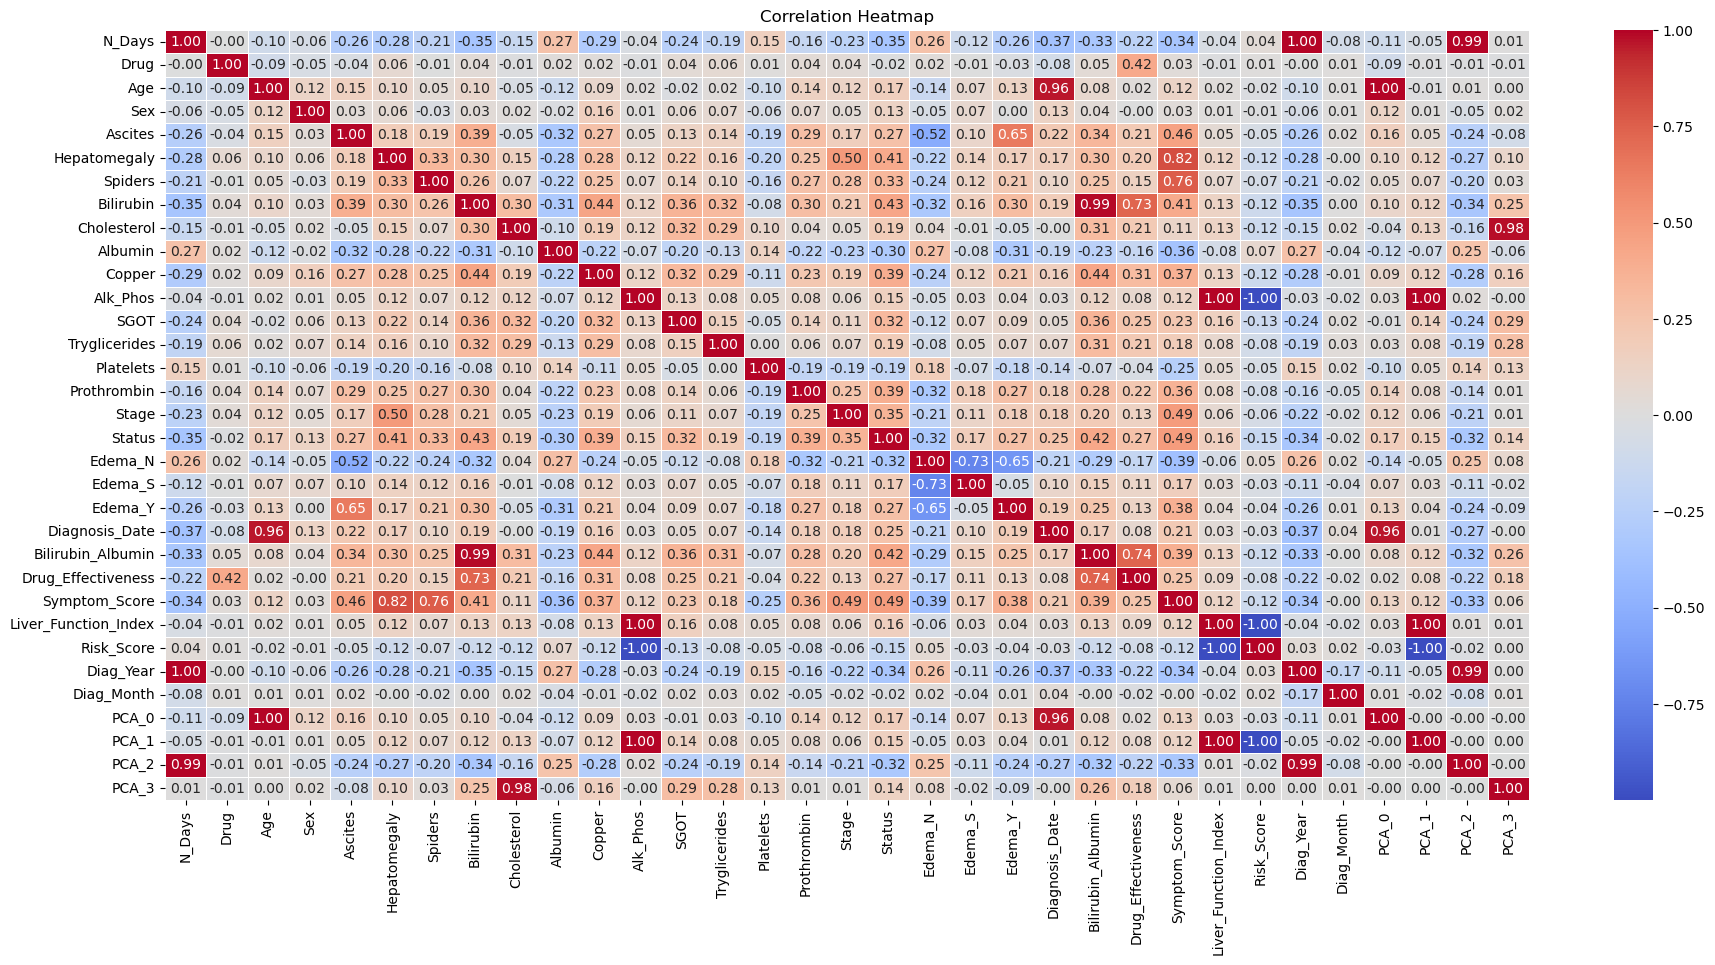

,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Status,Edema_N,Edema_S,Edema_Y,Diagnosis_Date,Bilirubin_Albumin,Drug_Effectiveness,Symptom_Score,Liver_Function_Index,Risk_Score,Diag_Year,Diag_Month,PCA_0,PCA_1,PCA_2,PCA_3
N_Days,1.000000,-0.001407,-0.098395,-0.059244,-0.261341,-0.283685,-0.211334,-0.349379,-0.152974,0.265068,-0.289716,-0.035694,-0.243503,-0.192147,0.149884,-0.162185,-0.225486,-0.345571,0.264931,-0.115071,-0.258567,-0.369067,-0.334036,-0.219731,-0.344936,-0.042282,0.035057,0.995521,-0.079339,-1.080813e-01,-4.859593e-02,9.929378e-01,5.324046e-03
Drug,-0.001407,1.000000,-0.086039,-0.045865,-0.035736,0.064676,-0.007136,0.038063,-0.011560,0.020019,0.020086,-0.013298,0.044667,0.062391,0.008791,0.043660,0.036082,-0.015404,0.024237,-0.005731,-0.028982,-0.079965,0.046598,0.416492,0.026094,-0.012053,0.013380,-0.002435,0.013943,-8.602933e-02,-1.049485e-02,-1.129493e-02,-1.299528e-02
Age,-0.098395,-0.086039,1.000000,0.121302,0.154636,0.097504,0.046765,0.096621,-0.045907,-0.119886,0.087528,0.022049,-0.016313,0.023172,-0.103327,0.141924,0.121071,0.169755,-0.142200,0.073413,0.125845,0.961207,0.079771,0.017371,0.121416,0.021727,-0.021884,-0.098528,0.014323,9.999185e-01,-8.724111e-03,9.317993e-03,1.814752e-04
Sex,-0.059244,-0.045865,0.121302,1.000000,0.032806,0.056046,-0.028313,0.032644,0.020285,-0.023134,0.156593,0.012998,0.061507,0.066504,-0.055126,0.070083,0.046011,0.126990,-0.054237,0.071171,0.000052,0.129709,0.037667,-0.002792,0.027149,0.014545,-0.012940,-0.059965,0.014479,1.218320e-01,1.007234e-02,-4.625073e-02,2.130309e-02
Ascites,-0.261341,-0.035736,0.154636,0.032806,1.000000,0.182479,0.185742,0.390076,-0.045470,-0.321657,0.273141,0.047888,0.127291,0.139789,-0.190167,0.285274,0.168271,0.270501,-0.518227,0.098035,0.646889,0.216857,0.337244,0.209223,0.456304,0.051598,-0.047184,-0.259913,0.019822,1.573569e-01,4.699092e-02,-2.437866e-01,-7.990064e-02
Hepatomegaly,-0.283685,0.064676,0.097504,0.056046,0.182479,1.000000,0.333569,0.304595,0.149095,-0.281125,0.282259,0.117456,0.215374,0.160226,-0.201822,0.250178,0.496628,0.412057,-0.221539,0.136180,0.171839,0.169692,0.295157,0.196735,0.817631,0.122939,-0.116929,-0.280018,-0.001541,1.010592e-01,1.189791e-01,-2.698640e-01,1.005555e-01
Spiders,-0.211334,-0.007136,0.046765,-0.028313,0.185742,0.333569,1.000000,0.255282,0.065904,-0.217805,0.253272,0.069275,0.139954,0.096960,-0.163626,0.272595,0.280913,0.331159,-0.240567,0.122902,0.214336,0.102251,0.247751,0.145514,0.764199,0.072971,-0.068823,-0.207021,-0.016984,4.930149e-02,7.119847e-02,-2.045460e-01,3.006333e-02
Bilirubin,-0.349379,0.038063,0.096621,0.032644,0.390076,0.304595,0.255282,1.000000,0.297645,-0.313375,0.441065,0.118704,0.356378,0.319081,-0.078719,0.296031,0.209114,0.432381,-0.324215,0.156161,0.299387,0.187076,0.988828,0.728698,0.412505,0.129071,-0.116806,-0.345184,0.002588,1.007929e-01,1.215585e-01,-3.368189e-01,2.512356e-01
Cholesterol,-0.152974,-0.011560,-0.045907,0.020285,-0.045470,0.149095,0.065904,0.297645,1.000000,-0.096964,0.188834,0.124341,0.323234,0.289180,0.095890,0.039158,0.045740,0.188549,0.043073,-0.007780,-0.054176,-0.000474,0.307122,0.210029,0.112050,0.132512,-0.123796,-0.153382,0.023416,-4.348786e-02,1.295918e-01,-1.576704e-01,9.769337e-01
Albumin,0.265068,0.020019,-0.119886,-0.023134,-0.321657,-0.281125,-0.217805,-0.313375,-0.096964,1.000000,-0.222443,-0.072266,-0.201846,-0.129330,0.138183,-0.217057,-0.229858,-0.304025,0.274133,-0.081596,-0.309164,-0.185435,-0.228911,-0.157441,-0.361880,-0.077472,0.071840,0.265710,-0.041812,-1.228634e-01,-7.272535e-02,2.506496e-01,-5.823455e-02


In [156]:
corr_heatmap(train_df_mod)

In [157]:
train_df_mod.columns

Index(['N_Days', 'Drug', 'Age', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders',
       'Bilirubin', 'Cholesterol', 'Albumin', 'Copper', 'Alk_Phos', 'SGOT',
       'Tryglicerides', 'Platelets', 'Prothrombin', 'Stage', 'Status',
       'Edema_N', 'Edema_S', 'Edema_Y', 'Diagnosis_Date', 'Age_Years',
       'Age_Group', 'Bilirubin_Albumin', 'Drug_Effectiveness', 'Symptom_Score',
       'Symptom_Score_000FalseFalseTrue', 'Symptom_Score_000FalseTrueFalse',
       'Symptom_Score_000TrueFalseFalse', 'Symptom_Score_001FalseFalseTrue',
       'Symptom_Score_001FalseTrueFalse', 'Symptom_Score_001TrueFalseFalse',
       'Symptom_Score_010FalseFalseTrue', 'Symptom_Score_010FalseTrueFalse',
       'Symptom_Score_010TrueFalseFalse', 'Symptom_Score_011FalseFalseTrue',
       'Symptom_Score_011FalseTrueFalse', 'Symptom_Score_011TrueFalseFalse',
       'Symptom_Score_100FalseFalseTrue', 'Symptom_Score_100FalseTrueFalse',
       'Symptom_Score_101FalseFalseTrue', 'Symptom_Score_101TrueFalseFalse',
       'S

In [158]:
# All
# FEATS = df_train_mod.drop(LABEL, axis=1).columns.tolist()
# Some
# FEATS = ['Platelets', 'Copper', 'Alk_Phos', 'Diagnosis_Date', 'SGOT', 'Age', 'N_Days', 'Cholesterol', 
#          'Tryglicerides', 'Albumin', 'Bilirubin', 'Prothrombin', 'Symptom_Score', 'Stage', 'Drug', 
#          'Hepatomegaly', 'Spiders', 'Sex', 'Edema_N', 'Edema_S', 'Edema_Y']
FEATS = ['Platelets', 'Copper', 'Alk_Phos', 'Diagnosis_Date', 'SGOT', 'Age', 'N_Days', 'Cholesterol', 
         'Tryglicerides', 'Albumin', 'Bilirubin', 'Prothrombin', 'Symptom_Score', 'Stage']

# Columns to exclude
# exlcude_columns = ['Edema_N', 'Platelets', 'Albumin', 'N_Days', 'Diag_year', 'Risk_Score', 'Diag_Month', 'PCA_0','PCA_1','PCA_2','PCA_3', 'Status']
exlcude_columns = ['Edema_N', 'Platelets', 'Albumin', 'N_Days', 'Diag_year', 'Risk_Score', 'Diag_Month', 'PCA_0','PCA_1','PCA_2','PCA_3', 'Status', 'Age_Group',
                   'Spiders', 'Hepatomegaly','Symptom_Score', 'Drug_Effectiveness', 'Stage', 'Sex', 'Symptom_Score_000FalseFalseTrue', 'Symptom_Score_000FalseTrueFalse',
                   'Symptom_Score_000TrueFalseFalse', 'Symptom_Score_001FalseFalseTrue',
                   'Symptom_Score_001FalseTrueFalse', 'Symptom_Score_001TrueFalseFalse',
                   'Symptom_Score_010FalseFalseTrue', 'Symptom_Score_010FalseTrueFalse',
                   'Symptom_Score_010TrueFalseFalse', 'Symptom_Score_011FalseFalseTrue',
                   'Symptom_Score_011FalseTrueFalse', 'Symptom_Score_011TrueFalseFalse',
                   'Symptom_Score_100FalseFalseTrue', 'Symptom_Score_100FalseTrueFalse',
                   'Symptom_Score_100TrueFalseFalse', 'Symptom_Score_101FalseFalseTrue',
                   'Symptom_Score_101FalseTrueFalse', 'Symptom_Score_101TrueFalseFalse',
                   'Symptom_Score_110FalseFalseTrue', 'Symptom_Score_110FalseTrueFalse',
                   'Symptom_Score_110TrueFalseFalse', 'Symptom_Score_111FalseFalseTrue',
                   'Symptom_Score_111FalseTrueFalse', 'Symptom_Score_111TrueFalseFalse',
                   'Ascites', 'Drug', 'Edema_Y','PCA_0', 'PCA_1', 'PCA_2', 'PCA_3']
FEATS2 = list(set(train_df_mod)-set(exlcude_columns))

FEATS_PCA = ['PCA_0','PCA_1','PCA_2','PCA_3']

# FEATS = FEATS + pca_c_names
# FEATS = sel_feats.tolist()
print(f"Number of feats: {len(FEATS)}")
print(f"Features used: {FEATS}")

print(f"\nNumber of feats 2: {len(FEATS2)}")
print(f"Features used 2: {FEATS2}")



Number of feats: 14
Features used: ['Platelets', 'Copper', 'Alk_Phos', 'Diagnosis_Date', 'SGOT', 'Age', 'N_Days', 'Cholesterol', 'Tryglicerides', 'Albumin', 'Bilirubin', 'Prothrombin', 'Symptom_Score', 'Stage']

Number of feats 2: 14
Features used 2: ['Diag_Year', 'Age_Years', 'Edema_S', 'Diagnosis_Date', 'Tryglicerides', 'Prothrombin', 'Age', 'Bilirubin', 'Bilirubin_Albumin', 'Liver_Function_Index', 'Cholesterol', 'Copper', 'SGOT', 'Alk_Phos']


In [159]:
# Just use the selected features
df_train_final = train_df_mod[FEATS + [LABEL]]
df_test_final = test_df_mod[FEATS+[LABEL]]
test_real_df_final = test_df_real_mod[FEATS]

df_train_final2 = train_df_mod[FEATS2 + [LABEL]]
df_test_final2 = test_df_mod[FEATS2+[LABEL]]
test_real_df_final2 = test_df_real_mod[FEATS2]

df_train_final_pca = train_df_mod[FEATS_PCA + [LABEL]]
df_test_final_pca = test_df_mod[FEATS_PCA+[LABEL]]
test_real_df_final_pca = test_df_real_mod[FEATS_PCA]



In [160]:
df_train_final2.columns

Index(['Diag_Year', 'Age_Years', 'Edema_S', 'Diagnosis_Date', 'Tryglicerides',
       'Prothrombin', 'Age', 'Bilirubin', 'Bilirubin_Albumin',
       'Liver_Function_Index', 'Cholesterol', 'Copper', 'SGOT', 'Alk_Phos',
       'Status'],
      dtype='object')

### Selección de Algoritmos

In [161]:
# Local optuna optimization test (cross val score: .4129666179319006), 21 FEATS
xgb_params = {'objective': 'multi_logloss', 'early_stopping_rounds': 50, 'max_depth': 9, 'min_child_weight': 8, 'learning_rate': 0.0337716365315986, 'n_estimators': 733, 'subsample': 0.6927955384688348, 'colsample_bytree': 0.1234702658812108, 'reg_alpha': 0.18561628377665318, 'reg_lambda': 0.5565488299127089, 'random_state': 42}
xgb_params2 = {'objective': 'multi_logloss', 'max_depth': 9, 'min_child_weight': 8, 'n_estimators': 733, 'subsample': 0.6927955384688348, 'colsample_bytree': 0.1234702658812108, 'reg_alpha': 0.18561628377665318, 'reg_lambda': 0.5565488299127089, 'random_state': 42}

In [163]:
# %%time
################## SOLO FUNCIONA CON RANDOM FOREST, HAY QUE ARREGLAR ALGO EN LA FUNCIÓN 'VALIDATE_MODELS'###################

xgb_cl = xgb.XGBClassifier(**xgb_params)
rf_cl = RandomForestClassifier()
xgb_cl_2 = xgb.XGBClassifier(**xgb_params)
rf_cl_2 = RandomForestClassifier()
xgb_cl_3 = xgb.XGBClassifier(**xgb_params)
rf_cl_3 = RandomForestClassifier()


models = [
    # {"name": "xgb_cl", "model": xgb_cl, "feats": FEATS},
    {"name": "rf_cl", "model": rf_cl, "feats": FEATS}
]

models2 = [
    # {"name": "xgb_cl", "model": xgb_cl_2, "feats": FEATS2},
    {"name": "rf_cl", "model": rf_cl_2, "feats": FEATS2}
]
models3 = [
    # {"name": "xgb_cl", "model": xgb_cl_2, "feats": FEATS_PCA},
    {"name": "rf_cl", "model": rf_cl_3, "feats": FEATS_PCA}
]



Processing rf_cl...: 100%|██████████| 1/1 [00:07<00:00,  7.95s/it, Fold 10/10]


### Entrenamiento de Modelo(s)

In [ ]:
models, train_scores, val_scores = validate_models(models=models, 
                                                   data=df_train_final,
                                                   label=LABEL, 
                                                   n_splits=10,
                                                   n_repeats=1)
models2, train_scores2, val_scores2 = validate_models(models=models2, 
                                                   data=df_train_final2, 
                                                   label=LABEL,
                                                   n_splits=10,
                                                   n_repeats=1)
models_pca, train_scores_pca, val_scores_pca = validate_models(models=models3, 
                                                   data=df_train_final_pca, 
                                                   label=LABEL,
                                                   n_splits=10,
                                                   n_repeats=1)

# models2, train_scores = train_models(models=models2,
#                                      data=df_train_final,
#                                      label=LABEL,
#                                      n_splits=10,
#                                      n_repeats=1)

### Evaluación de Modelo(s)

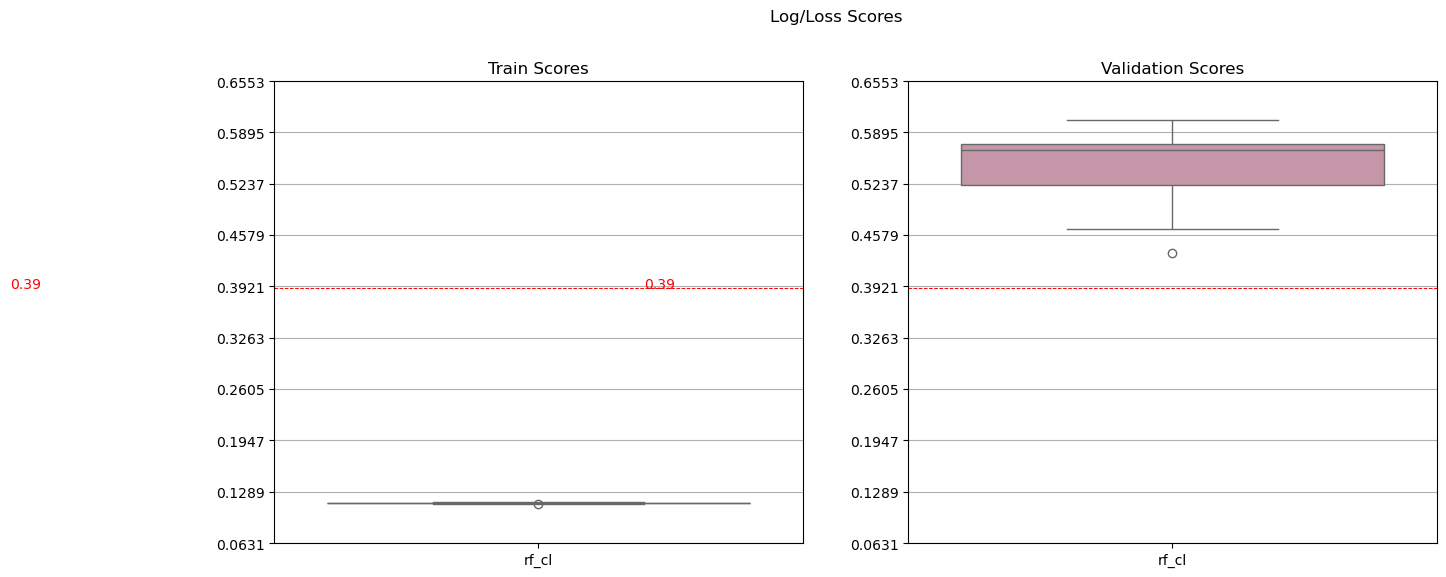

In [164]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

eps = .05
hl = .39
min_score = train_scores.min().min()-eps
max_score = val_scores.max().max()+eps

def calculate_ticks(min_score, max_score, num_ticks=10):
    return np.linspace(min_score, max_score, num_ticks)

ticks = calculate_ticks(min_score, max_score)

_ = sns.boxplot(train_scores, ax=axes[0])
_ = axes[0].set_title('Train Scores')
_ = axes[0].set_ylim(min_score, max_score)
_ = axes[0].set_yticks(ticks)
_ = axes[0].yaxis.grid(True)
_ = axes[0].axhline(y=hl, color='r', linestyle='--', lw=.7)
_ = axes[0].text(-1, hl, f"{hl}", c="red")

_ = sns.boxplot(val_scores, ax=axes[1])
_ = axes[1].set_title('Validation Scores')
_ = axes[1].set_ylim(min_score, max_score)
_ = axes[1].set_yticks(ticks)
_ = axes[1].yaxis.grid(True)
_ = axes[1].axhline(y=hl, color='r', linestyle='--', lw=.7)
_ = axes[1].text(-1, hl, f"{hl}", c="red")

fig.suptitle("Log/Loss Scores", y=1)  # Add a common title above the subplots
plt.show()


In [166]:
# Assuming `train_scores` and `val_scores` are DataFrames with scores for each model

# Separate the scores for xgb_cl and rf_cl models
xgb_train_scores = train_scores["xgb_cl"]
xgb_val_scores = val_scores["xgb_cl"]
rf_train_scores = train_scores["rf_cl"]
rf_val_scores = val_scores["rf_cl"]

# Print results in DataFrame
model_res = pd.concat([xgb_train_scores.describe(), xgb_val_scores.describe(), rf_train_scores.describe(), rf_val_scores.describe()], axis=1)
model_res.columns = ['XGB Train', 'XGB Validation', 'RF Train', 'RF Validation']
print(model_res)

# Plot results as lineplot
plt.figure(figsize=(10, 6))
_ = sns.lineplot(data=pd.concat([xgb_train_scores, xgb_val_scores, rf_train_scores, rf_val_scores], keys=["XGB Train", "XGB Validation", "RF Train", "RF Validation"], axis=1), markers=True, dashes=False, palette=["blue", "blue", "green", "green"])
plt.axhline(y=0.39, color='r', linestyle='--', lw=.5, label='Threshold (0.39)')

# Set the same color for both lines in the legend
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(loc='upper right')

plt.title('XGB and RF Train vs Validation Scores')
plt.xlabel('Index')
plt.ylabel('Scores')
plt.show()


KeyError: 'xgb_cl'

In [167]:
class MyAvgVoting(BaseEstimator, ClassifierMixin):
    """A basic voting method that just averages all estimator predictions and 
    predicts the class with the highest vote."""
    def __init__(self, estimators, weighted=False):
        self.estimators = estimators
        # Whether to average according to validation scores
        self.weighted = weighted

    def fit(self, X, y):
        for _, est in self.estimators:
            est["model"].fit(X, y)
        return self
    
    def create_avg_prob_predictions(self, X):
        predictions = np.array([est["model"].predict_proba(X) for est in self.estimators])
        if self.weighted:
            # Note: we need the inverse of the val_score since lower values are "better"
            weights = [{"name": est["name"], "value": 1/est["avg_val_score"]} for est in self.estimators]
            print(f"Weights are:\n{pd.DataFrame(weights)}")
            return np.average(predictions, axis=0, weights=[w["value"] for w in weights])
        return np.average(predictions, axis=0)
            
    def predict(self, X):
        avg_predictions = self.create_avg_prob_predictions(X)
        return np.argmax(avg_predictions, axis=1)

    def predict_proba(self, X):
        avg_predictions = self.create_avg_prob_predictions(X)
        return avg_predictions

    def score(self, X, y):
        pass

voting_ests = models
voting_clf = MyAvgVoting(voting_ests, weighted=False) 
# no fitting needed

In [168]:
voting_clf

MyAvgVoting(estimators=[{'avg_val_score': 0.5445094437582819,
                         'feats': ['Platelets', 'Copper', 'Alk_Phos',
                                   'Diagnosis_Date', 'SGOT', 'Age', 'N_Days',
                                   'Cholesterol', 'Tryglicerides', 'Albumin',
                                   'Bilirubin', 'Prothrombin', 'Symptom_Score',
                                   'Stage'],
                         'model': RandomForestClassifier(), 'name': 'rf_cl'}])

In [169]:
model_fin = models[0]['model']
model_fin2 = models2[0]['model']
model_fin_pca = models_pca[0]['model']

In [171]:
y_pred_train = model_fin.predict(df_train_final[FEATS])
y_pred_test = model_fin.predict(df_test_final[FEATS])
y_pred_test_real = model_fin.predict(test_real_df_final[FEATS])

y_pred_train2 = model_fin2.predict(df_train_final2[FEATS2])
y_pred_test2 = model_fin2.predict(df_test_final2[FEATS2])
y_pred_test_real2 = model_fin2.predict(test_real_df_final2[FEATS2])

y_pred_train_pca = model_fin_pca.predict(df_train_final_pca[FEATS_PCA])
y_pred_test_pca = model_fin_pca.predict(df_test_final_pca[FEATS_PCA])
y_pred_test_real_pca = model_fin_pca.predict(test_real_df_final_pca[FEATS_PCA])

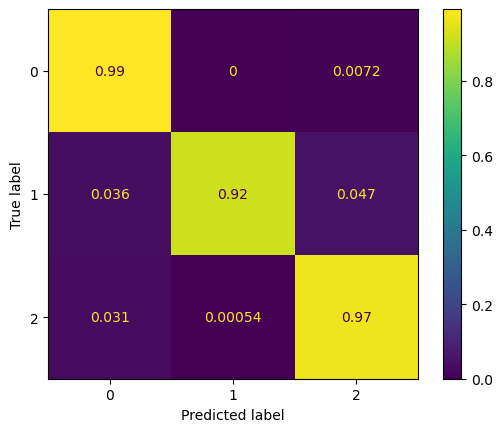

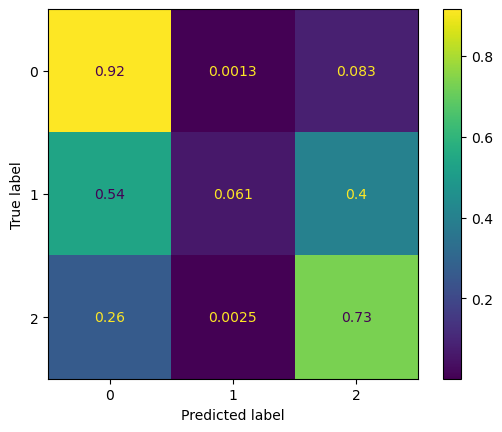

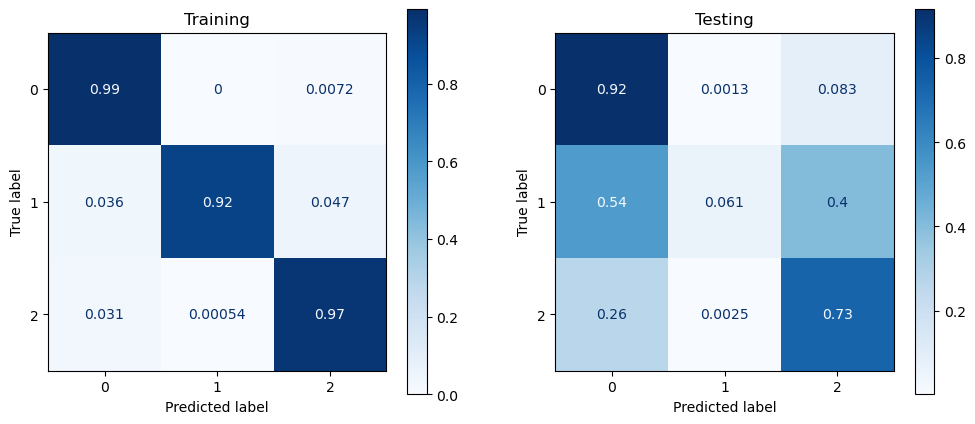

In [172]:

disp_train = ConfusionMatrixDisplay.from_predictions(df_train_final[LABEL], y_pred_train, normalize='true')
disp_test = ConfusionMatrixDisplay.from_predictions(df_test_final[LABEL], y_pred_test, normalize='true')

fig, axs = plt.subplots(1, 2, figsize=(12, 5))
disp_train.plot(ax=axs[0], cmap='Blues')
axs[0].set_title("Training")
disp_test.plot(ax=axs[1], cmap='Blues')
axs[1].set_title("Testing")

plt.show()



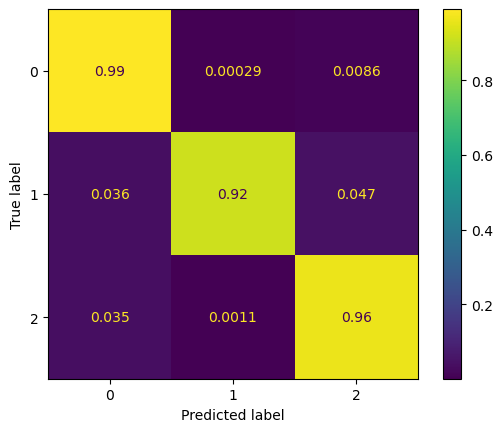

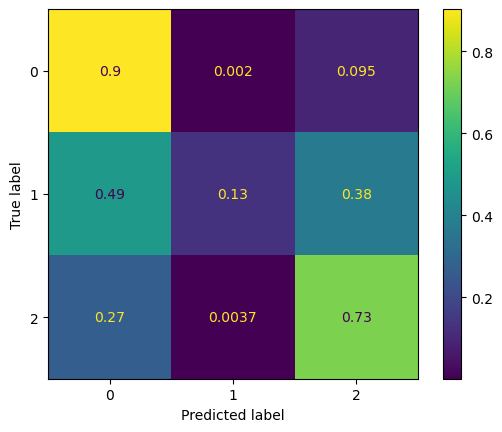

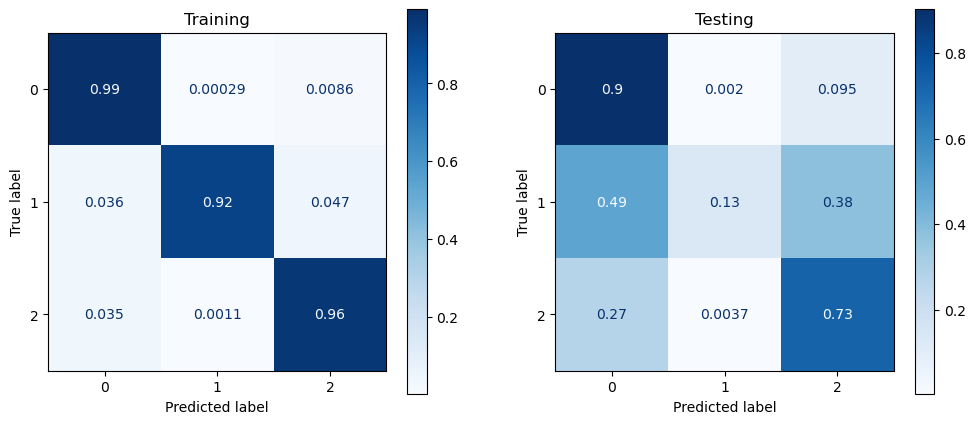

In [173]:

disp_train2 = ConfusionMatrixDisplay.from_predictions(df_train_final2[LABEL], y_pred_train2, normalize='true')
disp_test2 = ConfusionMatrixDisplay.from_predictions(df_test_final2[LABEL], y_pred_test2, normalize='true')

fig, axs = plt.subplots(1, 2, figsize=(12, 5))
disp_train2.plot(ax=axs[0], cmap='Blues')
axs[0].set_title("Training")
disp_test2.plot(ax=axs[1], cmap='Blues')
axs[1].set_title("Testing")

plt.show()

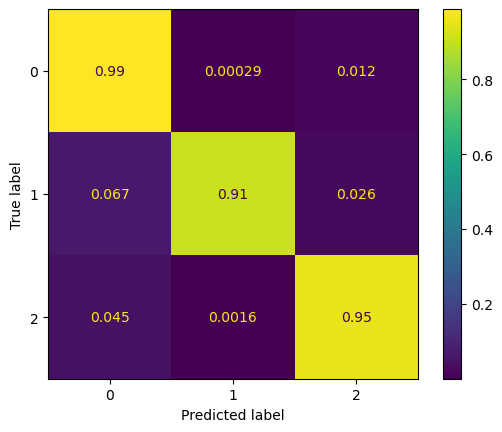

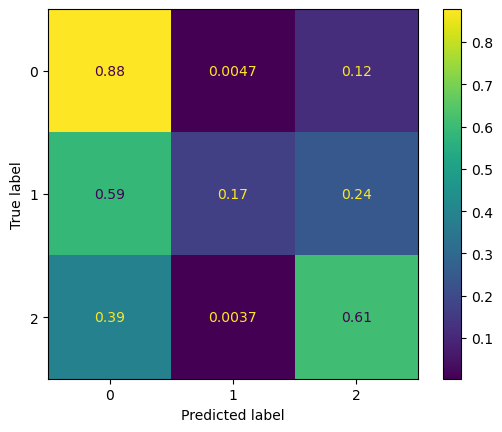

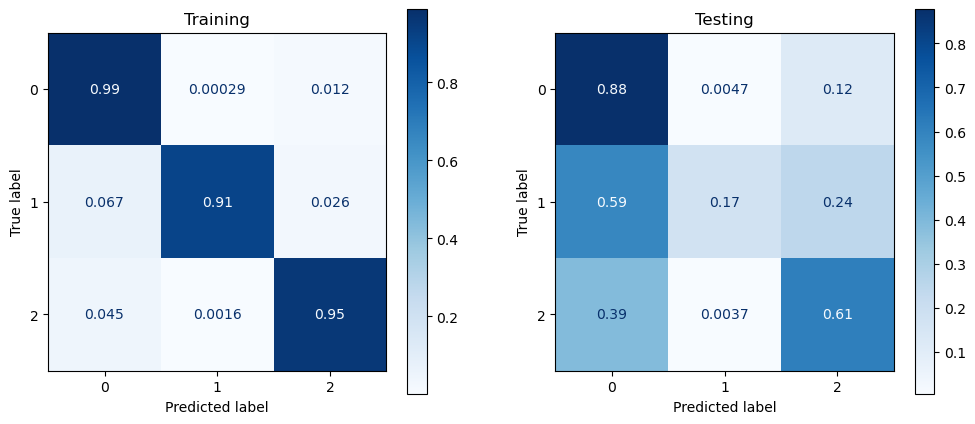

In [174]:

disp_train2 = ConfusionMatrixDisplay.from_predictions(df_train_final_pca[LABEL], y_pred_train_pca, normalize='true')
disp_test2 = ConfusionMatrixDisplay.from_predictions(df_test_final_pca[LABEL], y_pred_test_pca, normalize='true')

fig, axs = plt.subplots(1, 2, figsize=(12, 5))
disp_train2.plot(ax=axs[0], cmap='Blues')
axs[0].set_title("Training")
disp_test2.plot(ax=axs[1], cmap='Blues')
axs[1].set_title("Testing")

plt.show()

In [175]:
print(f"Clssification report Training: ")
print(classification_report(df_train_final[LABEL],y_pred_train))
print(f"\nClassification Report Testing: ")
print(classification_report(df_test_final[LABEL],y_pred_test))
print()
print(f"Clssification report Training: ")
print(classification_report(df_train_final2[LABEL],y_pred_train2))
print(f"\nClassification Report Testing: ")
print(classification_report(df_test_final2[LABEL],y_pred_test2))
print()
print(f"Clssification report Training: ")
print(classification_report(df_train_final_pca[LABEL],y_pred_train_pca))
print(f"\nClassification Report Testing: ")
print(classification_report(df_test_final_pca[LABEL],y_pred_test_pca))


Clssification report Training: 
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      3475
           1       0.99      0.92      0.95       193
           2       0.98      0.97      0.98      1865

    accuracy                           0.98      5533
   macro avg       0.99      0.96      0.97      5533
weighted avg       0.98      0.98      0.98      5533


Classification Report Testing: 
              precision    recall  f1-score   support

           0       0.84      0.92      0.88      1490
           1       0.56      0.06      0.11        82
           2       0.79      0.73      0.76       800

    accuracy                           0.83      2372
   macro avg       0.73      0.57      0.58      2372
weighted avg       0.81      0.83      0.81      2372


Clssification report Training: 
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      3475
           1       0.98      0.

In [176]:
y_pred_train_proba = model_fin.predict_proba(df_train_final[FEATS])
y_pred_test_proba = model_fin.predict_proba(df_test_final[FEATS])
y_pred_test_real_proba = model_fin.predict_proba(test_real_df_final[FEATS])
assert y_pred_test_proba.shape == (test_df.shape[0], 3)

y_pred_train_proba2 = model_fin2.predict_proba(df_train_final2[FEATS2])
y_pred_test_proba2 = model_fin2.predict_proba(df_test_final2[FEATS2])
y_pred_test_real_proba2 = model_fin2.predict_proba(test_real_df_final2[FEATS2])


#### Probabilidades por clase usando Dataset de Testing Artificial

In [177]:
df_y_probs_labels = ["Status_C", "Status_CL", "Status_D"]

df_y_probs = pd.DataFrame(
    {"id": test_IDs, **dict(zip(df_y_probs_labels, y_pred_test_proba.T))}
)
print(df_y_probs.head())

df_y_probs2 = pd.DataFrame(
    {"id": test_IDs, **dict(zip(df_y_probs_labels, y_pred_test_proba2.T))}
)
print(df_y_probs2.head())


        id  Status_C  Status_CL  Status_D
5754  5754      0.06       0.01      0.93
420    420      0.59       0.08      0.33
3128  3128      0.94       0.02      0.04
3867  3867      0.03       0.03      0.94
4426  4426      0.51       0.06      0.43
        id  Status_C  Status_CL  Status_D
5754  5754      0.09       0.03      0.88
420    420      0.82       0.04      0.14
3128  3128      0.92       0.01      0.07
3867  3867      0.05       0.00      0.95
4426  4426      0.64       0.05      0.31


#### Probabilidades por clase usando Dataset de Testing 'Real'

In [178]:
df_y_probs_real = pd.DataFrame(
    {"id": test_IDs_real, **dict(zip(df_y_probs_labels, y_pred_test_real_proba.T))}
)
print(df_y_probs_real.head())

df_y_probs_real2 = pd.DataFrame(
    {"id": test_IDs_real, **dict(zip(df_y_probs_labels, y_pred_test_real_proba2.T))}
)
print(df_y_probs_real2.head())

     id  Status_C  Status_CL  Status_D
0  7905      0.65       0.06      0.29
1  7906      0.67       0.12      0.21
2  7907      0.19       0.07      0.74
3  7908      0.89       0.02      0.09
4  7909      0.64       0.14      0.22
     id  Status_C  Status_CL  Status_D
0  7905      0.53       0.05      0.42
1  7906      0.58       0.12      0.30
2  7907      0.28       0.12      0.60
3  7908      0.90       0.02      0.08
4  7909      0.79       0.06      0.15


In [179]:
df_y_probs[df_y_probs['id']==2411]

,id,Status_C,Status_CL,Status_D


In [180]:
df_y_probs_real[df_y_probs_real['id']==7908]

,id,Status_C,Status_CL,Status_D
3,7908,0.89,0.02,0.09


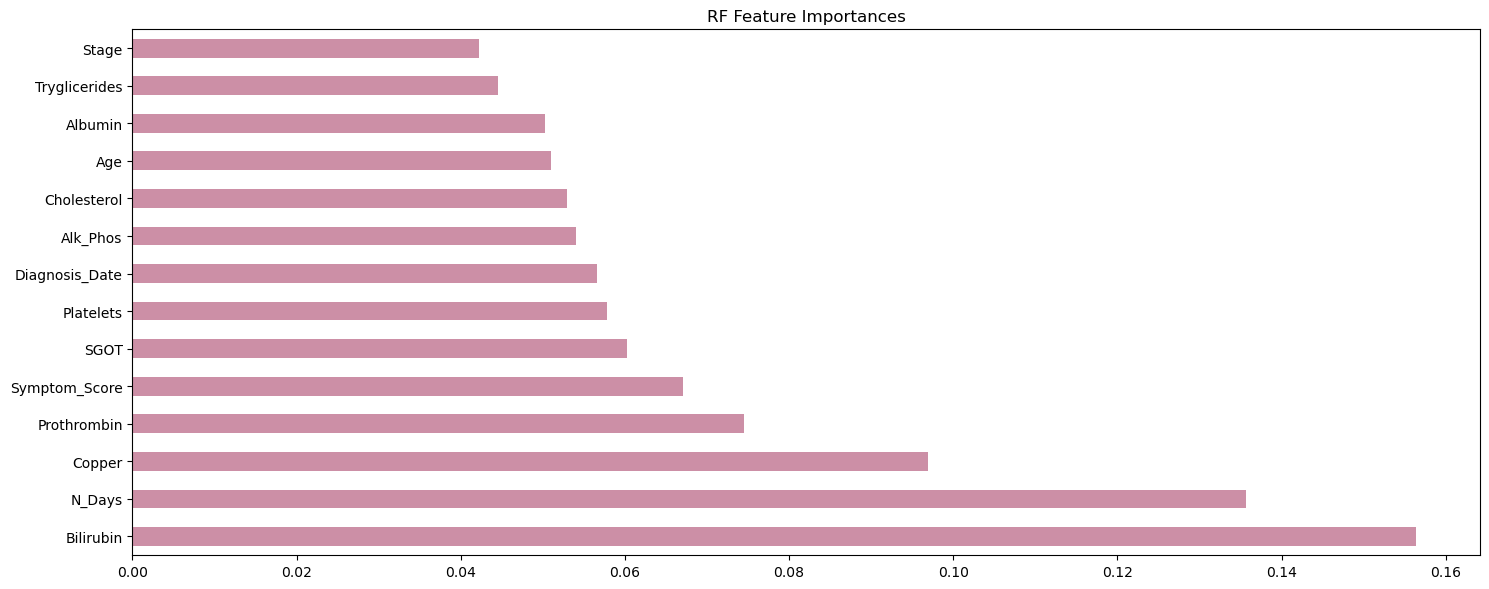

Total sorted RF importances: ['Bilirubin', 'N_Days', 'Copper', 'Prothrombin', 'Symptom_Score', 'SGOT', 'Platelets', 'Diagnosis_Date', 'Alk_Phos', 'Cholesterol', 'Age', 'Albumin', 'Tryglicerides', 'Stage']


In [181]:
# Creating Pandas Series for feature importances
rf_feat_importances = pd.Series(rf_cl.feature_importances_, index=df_train_final[FEATS].columns)

# Plotting both feature importances in subplots
fig, axes = plt.subplots(1, 1, figsize=(15, 6))

rf_feat_importances.nlargest(20).plot(kind='barh', title='RF Feature Importances')

plt.tight_layout()
plt.show()
print(f"Total sorted RF importances: {rf_feat_importances.nlargest(99).index.tolist()}")

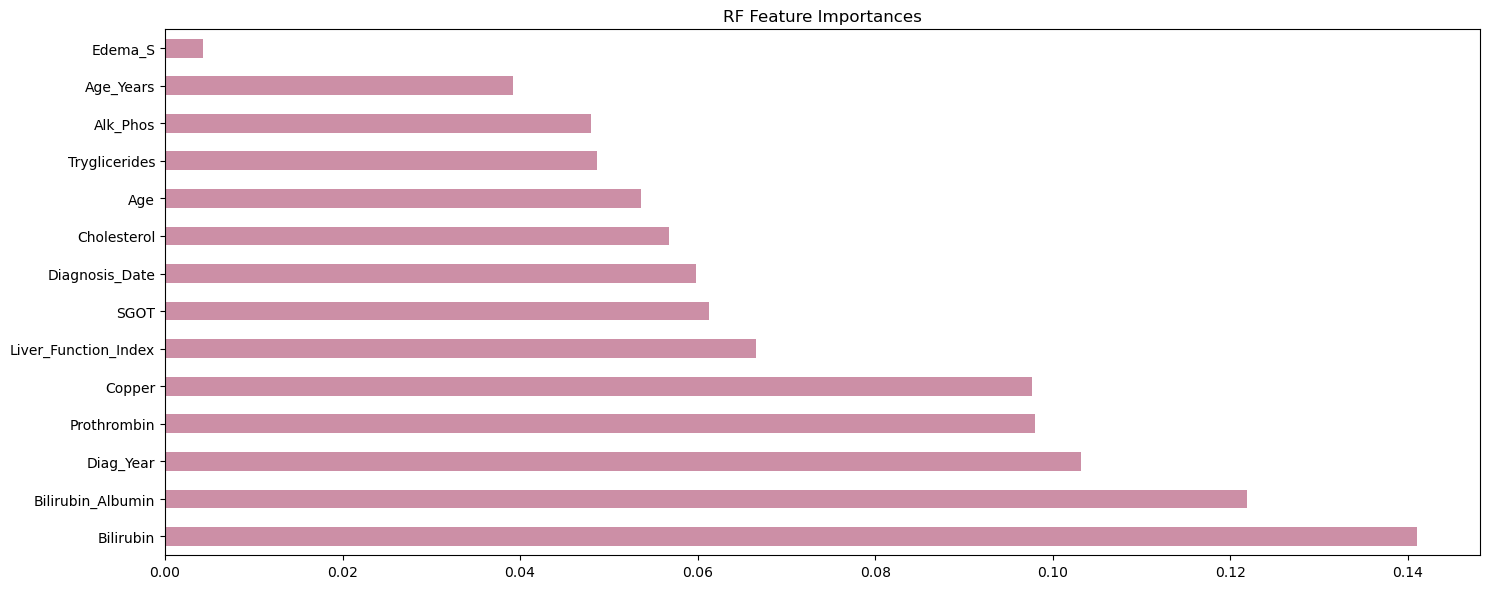

Total sorted XGBClassifier importances: ['Bilirubin', 'Bilirubin_Albumin', 'Diag_Year', 'Prothrombin', 'Copper', 'Liver_Function_Index', 'SGOT', 'Diagnosis_Date', 'Cholesterol', 'Age', 'Tryglicerides', 'Alk_Phos', 'Age_Years', 'Edema_S']


In [182]:
# Creating Pandas Series for feature importances
rf_feat_importances2 = pd.Series(rf_cl_2.feature_importances_, index=df_train_final2[FEATS2].columns)

# Plotting both feature importances in subplots
fig, axes = plt.subplots(1, 1, figsize=(15, 6))

rf_feat_importances2.nlargest(20).plot(kind='barh', title='RF Feature Importances')

plt.tight_layout()
plt.show()
print(f"Total sorted XGBClassifier importances: {rf_feat_importances2.nlargest(99).index.tolist()}")